Let's try to train a simple neural network architecture with bayesian inferencing

In [1]:
!pip install -U torch 

In [2]:
!pip3 install pyro-ppl==1.4.0

In [3]:
!pip install scipy==1.1.0

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from IPython import display
import os
from PIL import Image
from torch.utils.data.dataset import Dataset
from scipy.misc import imread

In [6]:
import pyro
from pyro.distributions import Normal, Categorical
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

In [7]:
%matplotlib inline

Defining a simple neural network architecture

In [8]:
class NN(nn.Module):
    """ Defining a fully connected layer with an output layer """
    def __init__(self, input_size, hidden_size, output_size):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        output = self.fc1(x)
        output = F.relu(output)
        output = self.out(output)
        return output

The softmax function is a good way of normalizing any value from [-infy, +infy] by applying an exponential function. However, it may create issues sometimes as we get large output values for small values of input. For example,

As the numbers are too big the exponents will probably blow up (computer cannot handle such big numbers) giving Nan as output.

From the softmax probabilities above, we can deduce that softmax can become numerically unstable for values with a very large range. Consider these values,
x = np.array([10, 2, 10000, 4])
print(softmax(x))

output: [0.0,  0.0, nan,  0.0]



Log softmax is the log of softmax function, mathematically,

zi - log(summation of exponentials of all zi's)

lesser computations of divisions and multiplications as addition is less computationally expensive.


In [9]:
log_softmax = nn.LogSoftmax(dim=1) #takes log of the softmax output for fast 
softmax = nn.Softmax(dim=1)

softplus = torch.nn.Softplus()
relu = nn.ReLU()

In [10]:
train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('mnist-data/', train=True, download=True,
                       transform=transforms.Compose([transforms.ToTensor(),])),
        batch_size=128, shuffle=True)

test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('mnist-data/', train=False, transform=transforms.Compose([transforms.ToTensor(),])
                       ),
        batch_size=128, shuffle=True)

In [11]:
net = NN(28*28, 1024, 10)

In [12]:
classes = ('0', '1', '2', '3',
           '4', '5', '6', '7', '8', '9')

In [13]:
def show_image(img):
  """Displaying an image """
  npimg = img.numpy()
  fig, ax = plt.subplots(figsize=(1, 1))
  ax.imshow(npimg,  cmap='gray', interpolation='nearest')
  plt.show()

A quick note on softplus : 
The Softplus function is a smooth approximation of the ReLU function that removes the knee in the ReLU function graph and replaces it with a smooth curve.
the output is always positive!

In [14]:

def guide(x_data, y_data):
    """ This function is used for training the weights and biases distribution and optimise the model"""
    # First layer weight distribution priors
    fc1w_mu = torch.randn_like(net.fc1.weight)
    fc1w_sigma = torch.randn_like(net.fc1.weight)
    fc1w_mu_param = pyro.param("fc1w_mu", fc1w_mu)
    fc1w_sigma_param = softplus(pyro.param("fc1w_sigma", fc1w_sigma))
    fc1w_prior = Normal(loc=fc1w_mu_param, scale=fc1w_sigma_param)
    # First layer bias distribution priors
    fc1b_mu = torch.randn_like(net.fc1.bias)
    fc1b_sigma = torch.randn_like(net.fc1.bias)
    fc1b_mu_param = pyro.param("fc1b_mu", fc1b_mu)
    fc1b_sigma_param = softplus(pyro.param("fc1b_sigma", fc1b_sigma))
    fc1b_prior = Normal(loc=fc1b_mu_param, scale=fc1b_sigma_param)
    # Output layer weight distribution priors
    outw_mu = torch.randn_like(net.out.weight)
    outw_sigma = torch.randn_like(net.out.weight)
    outw_mu_param = pyro.param("outw_mu", outw_mu)
    outw_sigma_param = softplus(pyro.param("outw_sigma", outw_sigma))
    outw_prior = Normal(loc=outw_mu_param, scale=outw_sigma_param).independent(1)
    # Output layer bias distribution priors
    outb_mu = torch.randn_like(net.out.bias)
    outb_sigma = torch.randn_like(net.out.bias)
    outb_mu_param = pyro.param("outb_mu", outb_mu)
    outb_sigma_param = softplus(pyro.param("outb_sigma", outb_sigma))
    outb_prior = Normal(loc=outb_mu_param, scale=outb_sigma_param)
    priors = {'fc1.weight': fc1w_prior, 'fc1.bias': fc1b_prior, 'out.weight': outw_prior, 'out.bias': outb_prior}
    
    lifted_module = pyro.random_module("module", net, priors)
    
    return lifted_module()

Initialising all bias and weights with normal distribution at the start, hence the likelihood of the parameters representing the data will be very low.

In the model() function, we have defined P(A) — the priors on weights and biases.

In [15]:
def model(x_data, y_data):
    """ We define the priors on weights and biases """
    fc1w_prior = Normal(loc=torch.zeros_like(net.fc1.weight), scale=torch.ones_like(net.fc1.weight))
    fc1b_prior = Normal(loc=torch.zeros_like(net.fc1.bias), scale=torch.ones_like(net.fc1.bias))
    
    outw_prior = Normal(loc=torch.zeros_like(net.out.weight), scale=torch.ones_like(net.out.weight))
    outb_prior = Normal(loc=torch.zeros_like(net.out.bias), scale=torch.ones_like(net.out.bias))
    
    priors = {'fc1.weight': fc1w_prior, 'fc1.bias': fc1b_prior,  'out.weight': outw_prior, 'out.bias': outb_prior}
    # lift module parameters to random variables sampled from the priors
    lifted_module = pyro.random_module("module", net, priors)
    # sample a regressor (which also samples w and b)
    lifted_reg_model = lifted_module()
    
    lhat = log_softmax(lifted_reg_model(x_data))

    event_dim = max(lhat.dim() - 1, y_data.dim())
    #telling the model that the output is a categorical variable equal to 10 classes
    pyro.sample("obs", Categorical(logits=lhat).to_event(event_dim), obs=y_data)

In [16]:
optim = Adam({"lr": 0.001})
svi = SVI(model, guide, optim, loss=Trace_ELBO())

Since calculating the "Evidence" in the denominator of bayes theorem is very time consuming, because :
1. Hypothetically, values of parameters Aj could range from -infinity to +infinity
2. For each value of Aj in that range, you have to run the model to find the likelihood of generating the input, output pairs you observe (the total dataset could be in millions of pairs)
3. There could be not one but many such parameters (j >> 1). In fact, for a neural network of our size, we have ~8million parameters (number of weights = 1024*28*28*10).


Hence, we try to use variational bayes method where we find the closest distribution (for example gaussian) to the posterior.

The gist of Variational Bayes methods is that since we can’t exactly compute the posterior, we can find the closest probability distribution to it that is a surrogate disribution with small set of paramters like mean or variance. So, after random initialization of those parameters in a “surrogate” distribution, you can do gradient descent and modify parameters of the distribution (like mean or variance) a little bit each time to see if the resulting distribution is closer to the posterior that you want to calculate. (If you’re thinking how do we know if resulting distribution is closer to the posterior if posterior is exactly what we want to calculate, you’ve understood the idea. The answer is that, surprisingly, we don’t need the exact posterior to find closeness between it and the other “surrogate” distribution. From model likelihood and model prior, we can find how close two distributions are using KL-Divergence measure.

From KL-Divergence formula, we try to use ELBO as loss function. 

ELBO (evidence lower bound) is a loss function just like cross entropy or mean squared error to track how "close" we are to the distribution.



In [17]:
num_iterations = 15
loss = 0

for j in range(num_iterations):
    loss = 0
    for batch_id, data in enumerate(train_loader):
        # calculate the loss and take a gradient step
        loss += svi.step(data[0].view(-1,28*28), data[1])
    normalizer_train = len(train_loader.dataset)
    total_epoch_loss_train = loss / normalizer_train
    
    print("Epoch ", j, " Loss ", total_epoch_loss_train)

/usr/local/lib/python3.7/dist-packages/pyro/primitives.py:406: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  "modules from `torch.nn.Module` instances.", FutureWarning)


Epoch  0  Loss  5214.822222446267
Epoch  1  Loss  3803.7218564522427
Epoch  2  Loss  2845.987932377672
Epoch  3  Loss  2151.7373882872103
Epoch  4  Loss  1647.7442601480006
Epoch  5  Loss  1277.3082127123514
Epoch  6  Loss  999.9699672053496
Epoch  7  Loss  789.1841042769591
Epoch  8  Loss  627.7216931297144
Epoch  9  Loss  502.2283314657847
Epoch  10  Loss  404.6503089343707
Epoch  11  Loss  329.55994814240137
Epoch  12  Loss  269.4030268874009
Epoch  13  Loss  223.5314849398772
Epoch  14  Loss  186.98078346862792


In [18]:
num_samples = 10
def predict(x):
  """Make different models based on num_samples and make predictions"""
  sampled_models = [guide(None, None) for _ in range(num_samples)]
  yhats = [model(x).data for model in sampled_models]
  mean = torch.mean(torch.stack(yhats), 0) #take model average of all classes for all models
  return np.argmax(mean.numpy(), axis=1) #take that class whose max prob is there

First thing to notice in the predict() function is that we’re using the learned guide() function (and not the model() function) to do predictions. This is because for model(), all we know is priors for weights and not the posterior. But for guide() after optimization iterations, the distribution given by the parameter values approximate the true posterior and so we can use it for predictions.

Second thing to notice is that for each prediction, we’re sampling a new set of weights and parameters 10 times (given by num_samples). This effectively means that we’re sampling a new neural network 10 times for making one prediction. As you will see later, this is what enables us to give uncertainities on outputs. In the case above, to make a prediction, we’re averaging final layer output values of the 10 sampled nets for the given input and taking the max activation value as the predicted digit. 



But note that in above case, we’re forcing our net to make a prediction in each case. We haven’t used the magic of Bayes theorem to enable our net to say: “I refuse to make a prediction here”.

To do that:

1. For an input image, take 100 samples of neural networks to get 100 different output values from the last layer
2. Convert those outputs (which are logsoftmaxed) into probabilities by exponentiating them
3. Now, given the input image, for each digit we have 100 probability values
4. We take median (50th percentile) of these 100 probability values as the threshold probability for each digit
5. If the threshold probability is greater than 0.2, we select the digit as a classification output from the network

In [19]:
def give_uncertainities(x):
  """Give the output of different models without averaging or taking max """
  sampled_models = [guide(None, None) for _ in range(num_samples)]
  yhats = [F.log_softmax(model(x.view(-1,28*28)).data, 1).detach().numpy() for model in sampled_models]
  return np.asarray(yhats)

/usr/local/lib/python3.7/dist-packages/pyro/primitives.py:406: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  "modules from `torch.nn.Module` instances.", FutureWarning)


Actual class  tensor(8)
Predicted with low certainty as  [8]  with probability  0.0


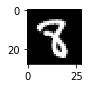

Actual class  tensor(7)
Predicted with low certainty as  [4]  with probability  0.0


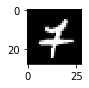

Actual class  tensor(8)
Predicted with low certainty as  [8]  with probability  0.0


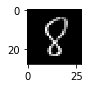

Actual class  tensor(6)
Predicted with low certainty as  [6]  with probability  0.0


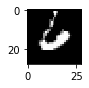

Actual class  tensor(0)
Predicted with low certainty as  [0]  with probability  0.0


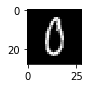

Actual class  tensor(0)
Predicted with low certainty as  [0]  with probability  0.0


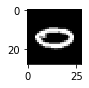

Actual class  tensor(9)
Predicted with low certainty as  [9]  with probability  2.2113408950535826e-15


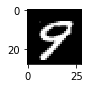

In [21]:
uncertain_images = []

for j, data in enumerate(test_loader):
  certain = False 
  images, labels = data
  for img in images:
    predicted = predict(img.view(-1,28*28))
    uncertainties = give_uncertainities(img)
    for c in range(len(classes)):
      histo_exp = []
      #for each class, try to get probability from each model
      for z in range(uncertainties.shape[0]):
        histo_exp.append(np.exp(uncertainties[z][0][c])) #converting the outputs to probabilities

      prob = np.percentile(histo_exp, 50) #sampling median probability for each class
      if(prob > 0.2): #select if network thinks this sample is 20% chance of this being a class
        certain = True 

    if not certain:
      print("Actual class ",labels[0])
      print("Predicted with low certainty as ",predicted, " with probability ",prob)
      show_image(img.reshape(28,28))
      uncertain_images.append(img.reshape(28,28))

    break